In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


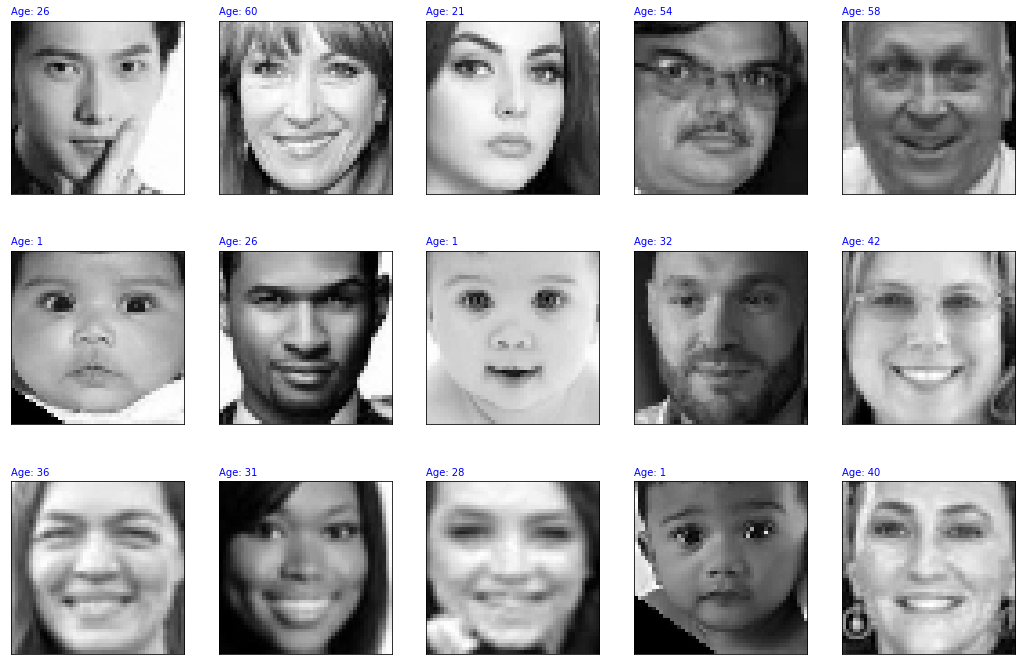

In [275]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image, ImageOps
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output

DATA_FILE = "drive/MyDrive/Age Prediction/age_gender.csv"

df = pd.read_csv(DATA_FILE)
df = shuffle(df)
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(), dtype="float32"))

plt.figure(figsize=(18, 12))

for i in range(15):  

    idx = np.random.randint(0, len(df))
    plt.subplot(3, 5, i+1)
    plt.imshow(df["pixels"].iloc[idx].reshape(48, 48), "gray")
    plt.title("Age: {}".format(df["age"].iloc[idx]), loc="left", color="blue", fontsize=10)
    plt.xticks([])
    plt.yticks([]) 
    plt.grid(False)

plt.show()

X = np.array(df["pixels"].tolist())
Y = df["age"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [114]:
class dataset(
    torch.utils.data.Dataset
    ):

  def __init__(
      self,
      X,
      Y,
      train=True
      ):
    
    self.images, self.targets, self.train = [], Y.tolist(), train

    for i in range(X.shape[0]):

      self.images.append(X[i, :].reshape(48, 48, 1))

  def __getitem__(
      self, 
      idx
      ):
    
    image, target = self.images[idx], self.targets[idx]

    if self.train:

      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor(),
          transforms.Normalize([0.5], [0.25])
          ])

    else:

      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.ToTensor(),
          transforms.Normalize([0.5], [0.25])
          ])

    image = transform(image)
    target = torch.tensor([target], dtype=torch.float32)
    
    return image, target

  def __len__(
      self
      ):

    return len(self.images)

In [115]:
train_dataset = dataset(X_train, Y_train, train=True)
test_dataset = dataset(X_test, Y_test, train=False)

In [116]:
class data_loader():

    def __init__(
        self,
        train_dataset,
        test_dataset
        ):
      
      train_batch_size, test_batch_size = 256, 256
      num_workers = 1

      self.train_loader = torch.utils.data.DataLoader(
          train_dataset, 
          batch_size=train_batch_size,
          shuffle=True,
          drop_last=True,
          num_workers=num_workers
          )

      self.test_loader = torch.utils.data.DataLoader(
          test_dataset, 
          batch_size=test_batch_size,
          shuffle=True,
          drop_last=True,
          num_workers=num_workers
          )

In [117]:
class my_model(
    nn.Module
    ): 

    def __init__(
        self
        ):

        super(my_model, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc_1 = nn.Linear(2048, 64)
        self.fc_2 = nn.Linear(64, 1)
        
    def forward(
        self, 
        x
        ):
      
        x = F.relu(F.max_pool2d(self.conv_1(x), 2))
        x = F.relu(F.max_pool2d(self.conv_2(x), 2))
        x = F.relu(F.max_pool2d(self.conv_3(x), 2))
        x = F.relu(self.fc_1(x.view(x.shape[0], -1)))
        x = self.fc_2(x)

        return x

In [118]:
class my_agent():

  def __init__(
      self,
      train_dataset,
      test_dataset
      ):

    self.data_loader = data_loader(train_dataset, test_dataset)
    self.model = my_model()

    if torch.cuda.is_available():

      torch.cuda.manual_seed(1)
      self.device = torch.device('cuda')
      torch.cuda.set_device(0)

    else:

      self.device = torch.device('cpu')
      torch.manual_seed(1)

    self.model.to(self.device)

    learning_rate = 2e-3
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    self.criterion = nn.L1Loss()

    self.current_epoch, self.epochs = 0, 50
    self.train_losses, self.test_losses = [], []

  def run(
      self
      ):

    for epoch in range(1, self.epochs + 1):

      self.current_epoch += 1
      self.train_epoch()
      self.test_epoch()

      if self.test_losses[-1] == min(self.test_losses):

        self.best_model = copy.deepcopy(self.model)

      print(f"Epoch [{self.current_epoch}/{self.epochs}]: \tCurrent Train Loss:", "{:.2f}".format(self.train_losses[-1]), "\tCurrent Test Loss:", "{:.2f}".format(self.test_losses[-1]), "\tBest Test Loss:", "{:.2f}".format(min(self.test_losses)))

      plt.figure()
      plt.plot(np.arange(1, self.current_epoch + 1), self.train_losses, linewidth=3, color=[1,0.3,0], label="Train")
      plt.plot(np.arange(1, self.current_epoch + 1), self.test_losses, linewidth=3, color=[0,0.3,1], label="Test")
      plt.legend()
      plt.xlabel("Epoch")
      plt.ylabel("L1 Loss")
      plt.title("Running Loss Plot")
      plt.show()

      clear_output(wait=True)

  def train_epoch(
      self
      ):
    
    self.model.train()

    train_loss = 0.0
    
    for (images, targets) in self.data_loader.train_loader:

      images = images.to(self.device)
      targets = targets.to(self.device)

      outputs = self.model(images)

      loss = self.criterion(outputs, targets)
      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      train_loss += loss.item() * images.size(0)

    self.train_losses.append(train_loss / len(self.data_loader.train_loader.sampler))

  def test_epoch(
      self
      ):
    
    self.model.eval()

    test_loss = 0.0

    with torch.no_grad():

      for (images, targets) in self.data_loader.test_loader:

        images = images.to(self.device)
        targets = targets.to(self.device)

        outputs = self.model(images)

        loss = self.criterion(outputs, targets)
        test_loss += loss.item() * images.size(0)

    self.test_losses.append(test_loss / len(self.data_loader.test_loader.sampler))

Epoch [50/50]: 	Current Train Loss: 6.16 	Current Test Loss: 8.20 	Best Test Loss: 7.92


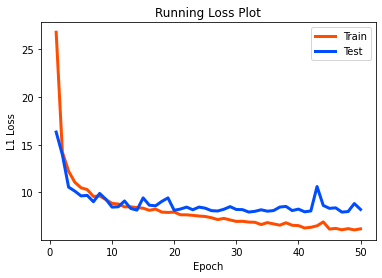

In [119]:
agent = my_agent(train_dataset, test_dataset)
agent.run()

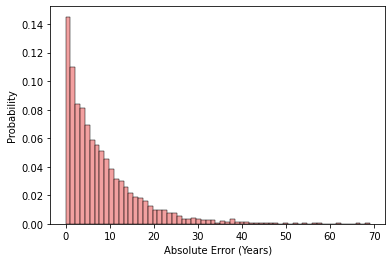

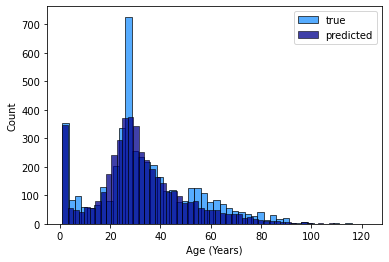

In [144]:
agent.best_model.eval()

age, age_pred = [], []

for (images, targets) in agent.data_loader.test_loader:

  images = images.to(agent.device)
  age += targets.cpu().detach().tolist()

  outputs = agent.best_model(images).cpu().detach()
  age_pred += outputs.cpu().detach().tolist()

age = np.array(age).reshape(-1)
age_pred = np.array(age_pred).reshape(-1)
error = np.abs(age - age_pred)

plt.figure()
sns.histplot(data=error, color="lightcoral", stat="probability")
plt.xlabel("Absolute Error (Years)")
plt.show()

plt.figure()
sns.histplot(data=age, color="dodgerblue", stat="count", label="true")
sns.histplot(data=age_pred, color="darkblue", stat="count", label="predicted")
plt.legend()
plt.xlabel("Age (Years)")
plt.show()

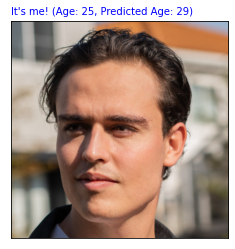

In [274]:
me = Image.open("drive/MyDrive/Age Prediction/me.PNG")

x = ImageOps.grayscale(me)
x = np.array(x.resize((48, 48))).reshape(48, 48, 1).astype("float32")

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.25])
    ])

x = transform(x).resize(1, 1, 48, 48).to(agent.device)

my_age_pred = agent.best_model(x).item()

plt.figure()
plt.imshow(np.array(me).reshape(598, 598, 3))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title(f"It's me! (Age: 25, Predicted Age: {round(my_age_pred)})", loc="left", color="blue", fontsize=10)
plt.show()